# Libraries

In [1]:
#!/usr/bin/env python3
# encoding: utf-8
import warnings
import os
warnings.filterwarnings("ignore")
import sys

from utilSD import per_missing, var_unicos, corr_top, corr_detail, crear_dummies, evaluar_rf

In [2]:
# Otras librerias 
import traceback
import logging
import pandas as pd
import numpy as np
from collections import Counter
import time
import datetime as dt
import dateutil.relativedelta
from datetime import timedelta,datetime,date,timedelta
import configparser
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
%matplotlib inline
pd.options.display.max_rows = 999

# EDA DS Challenge

## Read Raw

In [4]:
Data_raw = pd.read_csv("..\data\ds_challenge_2021.csv", sep=",")
Data_raw.sample(2)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
14598,2172,F,540.080226,2020-01-07,9,"{'model': 2020, 'device_score': 2, 'os': 'WEB'}",Abarrotes,NaN,Física,45000,60,Aceptada,False,0.0,5.400802,False
1803,275,F,32.731759,2020-01-04,12,"{'model': 2020, 'device_score': 4, 'os': 'ANDR...",Super,NaN,Física,65000,64,Aceptada,False,0.0,0.327318,False


In [5]:
Data_raw.isna().sum()/len(Data_raw)

ID_USER            0.000000
genero             0.000000
monto              0.000000
fecha              0.000000
hora               0.000000
dispositivo        0.000000
establecimiento    0.375125
ciudad             0.432919
tipo_tc            0.000000
linea_tc           0.000000
interes_tc         0.000000
status_txn         0.000000
is_prime           0.000000
dcto               0.000000
cashback           0.000000
fraude             0.000000
dtype: float64

In [6]:
Data_raw.dtypes#.to_dict()

ID_USER              int64
genero              object
monto              float64
fecha               object
hora                 int64
dispositivo         object
establecimiento     object
ciudad              object
tipo_tc             object
linea_tc             int64
interes_tc           int64
status_txn          object
is_prime              bool
dcto               float64
cashback           float64
fraude                bool
dtype: object

In [7]:
Data_raw['fraude'] = Data_raw['fraude'].astype(int)
Data_raw['is_prime'] = Data_raw['is_prime'].astype(int)

In [8]:
Data_raw['dispositivo'].value_counts(dropna=False)

{'model': 2020, 'device_score': 4, 'os': '%%'}         1411
{'model': 2020, 'device_score': 1, 'os': 'WEB'}        1388
{'model': 2020, 'device_score': 5, 'os': 'WEB'}        1377
{'model': 2020, 'device_score': 2, 'os': '.'}          1374
{'model': 2020, 'device_score': 5, 'os': 'ANDROID'}    1372
{'model': 2020, 'device_score': 2, 'os': '%%'}         1370
{'model': 2020, 'device_score': 2, 'os': 'WEB'}        1358
{'model': 2020, 'device_score': 3, 'os': '.'}          1355
{'model': 2020, 'device_score': 1, 'os': '%%'}         1355
{'model': 2020, 'device_score': 4, 'os': 'WEB'}        1354
{'model': 2020, 'device_score': 5, 'os': '%%'}         1348
{'model': 2020, 'device_score': 1, 'os': 'ANDROID'}    1344
{'model': 2020, 'device_score': 4, 'os': '.'}          1335
{'model': 2020, 'device_score': 4, 'os': 'ANDROID'}    1335
{'model': 2020, 'device_score': 5, 'os': '.'}          1334
{'model': 2020, 'device_score': 3, 'os': '%%'}         1324
{'model': 2020, 'device_score': 3, 'os':

In [9]:
dispositivo_json_cols = list(eval(Data_raw['dispositivo'].loc[0]).keys())
dispositivo_json_cols

['model', 'device_score', 'os']

In [10]:
list_data = list(Data_raw['dispositivo'].apply( lambda x: list( map(lambda x:str(x),list(eval(x).values()))) ) )
Data_raw.loc[:,dispositivo_json_cols] = pd.DataFrame(list_data,columns = dispositivo_json_cols)

In [11]:
Data_raw.drop(['dispositivo'], axis=1, inplace=True)
Data_raw.drop(['model'], axis=1, inplace=True)

Data_raw.sample(2)

,ID_USER,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,os
3886,590,F,131.510101,2020-01-08,16,NaN,NaN,Física,68000,64,Aceptada,0,0.000000,1.315101,0,2,ANDROID
9538,1429,F,912.429856,2020-01-30,23,MPago,Merida,Física,60000,56,En proceso,0,182.485971,7.299439,0,4,WEB


In [12]:
aux = var_unicos(Data_raw)
aux

,index,Unicos,Tipo
14,fraude,2,int32
7,tipo_tc,2,object
11,is_prime,2,int32
1,genero,3,object
10,status_txn,3,object
16,os,4,object
6,ciudad,5,object
15,device_score,5,object
5,establecimiento,6,object
4,hora,23,int64


In [13]:
Data_raw.shape

(26975, 17)

There are 4000 users **ID_USER** y 26975 *transacciones*

In [14]:
Data_raw['fraude'].value_counts(normalize=True)

0    0.969972
1    0.030028
Name: fraude, dtype: float64

The ratio of *fraudsters* is **3%**

In [15]:
aux = var_unicos(Data_raw)
vars_obs = list(aux[aux['Unicos']<10]['index'])
print(vars_obs)

['fraude', 'tipo_tc', 'is_prime', 'genero', 'status_txn', 'os', 'ciudad', 'device_score', 'establecimiento']


In [16]:
[col+' : '+str(list(Data_raw[col].factorize(na_sentinel=None)[1])) for col in vars_obs]

['fraude : [0, 1]',
 "tipo_tc : ['Física', 'Virtual']",
 'is_prime : [0, 1]',
 "genero : ['F', '--', 'M']",
 "status_txn : ['Aceptada', 'En proceso', 'Rechazada']",
 "os : ['ANDROID', '.', 'WEB', '%%']",
 "ciudad : ['Merida', 'Guadalajara', 'Toluca', 'Monterrey', nan]",
 "device_score : ['3', '1', '2', '4', '5']",
 "establecimiento : ['Super', 'MPago', 'Abarrotes', 'Farmacia', 'Restaurante', nan]"]

In [17]:
Data_raw['establecimiento'] = Data_raw['establecimiento'].fillna('No_definido')
Data_raw['ciudad'] = Data_raw['ciudad'].fillna('No_definido')
Data_raw['genero'] = Data_raw['genero'].replace({ "--" : "No_definido"})
Data_raw['os'] = Data_raw['os'].replace({ "%%" : "PERCENT" , "." : "POINT" })
Data_raw['tipo_tc'] = Data_raw['tipo_tc'].replace({ "Física" : "Fisica" })

In [18]:
Data_raw.isna().sum()/len(Data_raw)

ID_USER            0.0
genero             0.0
monto              0.0
fecha              0.0
hora               0.0
establecimiento    0.0
ciudad             0.0
tipo_tc            0.0
linea_tc           0.0
interes_tc         0.0
status_txn         0.0
is_prime           0.0
dcto               0.0
cashback           0.0
fraude             0.0
device_score       0.0
os                 0.0
dtype: float64

In [19]:
aux = var_unicos(Data_raw)
aux[aux['Unicos']<7]

,index,Unicos,Tipo
14,fraude,2,int32
7,tipo_tc,2,object
11,is_prime,2,int32
1,genero,3,object
10,status_txn,3,object
16,os,4,object
6,ciudad,5,object
15,device_score,5,object
5,establecimiento,6,object


In [20]:
[col+' : '+str(list(Data_raw[col].factorize(na_sentinel=None)[1])) for col in vars_obs]

['fraude : [0, 1]',
 "tipo_tc : ['Fisica', 'Virtual']",
 'is_prime : [0, 1]',
 "genero : ['F', 'No_definido', 'M']",
 "status_txn : ['Aceptada', 'En proceso', 'Rechazada']",
 "os : ['ANDROID', 'POINT', 'WEB', 'PERCENT']",
 "ciudad : ['Merida', 'Guadalajara', 'Toluca', 'Monterrey', 'No_definido']",
 "device_score : ['3', '1', '2', '4', '5']",
 "establecimiento : ['Super', 'No_definido', 'MPago', 'Abarrotes', 'Farmacia', 'Restaurante']"]

In [21]:
Data_raw.sample(2)

,ID_USER,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,os
20650,3041,M,381.703393,2020-01-04,1,No_definido,Guadalajara,Virtual,84000,37,Aceptada,1,0.0,7.634068,0,3,ANDROID
3176,485,F,899.629558,2020-01-19,20,Super,Merida,Virtual,49000,38,Aceptada,0,0.0,17.992591,0,1,POINT


In [22]:
Data_df = Data_raw.groupby('ID_USER').\
apply(lambda x: pd.Series(dict(
   
    cant_trxs = x['ID_USER'].count(),

    ciudad_mode = x['ciudad'].mode()[0], 
    os_mode = x['os'].mode()[0],   
    device_score_mode = x['device_score'].mode()[0],
    establecimiento_mode = x['establecimiento'].mode()[0], 
    tipo_tc_mode = x['tipo_tc'].mode()[0],
    
    monto_mean = x['monto'].mean(),
    monto_median = x['monto'].median(),
    monto_total = x['monto'].sum(),
    
    fraude = x['fraude'].max()
)))
#Data_df['ciudad_N'].value_counts(dropna=False)

In [23]:
print(Data_df.shape)
print(Data_df['fraude'].value_counts(normalize=True))
Data_df.sample(2)

(4000, 10)
0    0.83125
1    0.16875
Name: fraude, dtype: float64


,cant_trxs,ciudad_mode,os_mode,device_score_mode,establecimiento_mode,tipo_tc_mode,monto_mean,monto_median,monto_total,fraude
ID_USER,,,,,,,,,,
3827,9,Monterrey,ANDROID,1,No_definido,Fisica,431.32419,330.172964,3881.917714,0
80,5,Merida,PERCENT,1,Abarrotes,Fisica,369.66855,157.184351,1848.342750,0


In [24]:
aux = var_unicos(Data_df)
aux

,index,Unicos,Tipo
5,tipo_tc_mode,2,object
9,fraude,2,int64
2,os_mode,4,object
1,ciudad_mode,5,object
3,device_score_mode,5,object
4,establecimiento_mode,6,object
0,cant_trxs,42,int64
6,monto_mean,4000,float64
7,monto_median,4000,float64
8,monto_total,4000,float64


In [25]:
aux = var_unicos(Data_df)
vars_object = list(aux[aux['Tipo']=='object']['index'])
vars_num = list(aux[aux['Tipo']!='object']['index'])
print(vars_object)
print(vars_num)

['tipo_tc_mode', 'os_mode', 'ciudad_mode', 'device_score_mode', 'establecimiento_mode']
['fraude', 'cant_trxs', 'monto_mean', 'monto_median', 'monto_total']


In [26]:
df = Data_df[vars_object+['fraude']]
df.sample(3)

,tipo_tc_mode,os_mode,ciudad_mode,device_score_mode,establecimiento_mode,fraude
ID_USER,,,,,,
3234,Fisica,POINT,Merida,2,No_definido,0
2481,Fisica,ANDROID,Toluca,3,No_definido,0
1207,Fisica,PERCENT,Guadalajara,5,No_definido,1


In [27]:
from scipy.stats import chi2_contingency

factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

In [28]:
chi2 = np.array(chi2).reshape((6,6)) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # then a df for convenience
chi2

,tipo_tc_mode,os_mode,ciudad_mode,device_score_mode,establecimiento_mode,fraude
tipo_tc_mode,0.000000,2.439242,1.494439,1.902636,17.569410,12.364597
os_mode,2.439242,0.000000,11.863574,7.746899,11.997931,3.183249
ciudad_mode,1.494439,11.863574,0.000000,18.302001,18.589998,3.077696
device_score_mode,1.902636,7.746899,18.302001,0.000000,38.128582,1.238182
establecimiento_mode,17.569410,11.997931,18.589998,38.128582,0.000000,46.634215
fraude,12.364597,3.183249,3.077696,1.238182,46.634215,0.000000


In [29]:
target = 'fraude'
aux_unique = var_unicos(Data_df)
aux_list = []
for col in ['establecimiento_mode','tipo_tc_mode','os_mode','ciudad_mode']:
    print(col)
    aux = pd.concat([Data_df[col].value_counts(dropna=False).rename("#").sort_index(),
                    Data_df.groupby([col], dropna=False)[target].sum().rename("Target").sort_index(),
                    Data_df[col].value_counts(dropna=False, normalize=True).rename("per").sort_index()],axis=1)
    aux["Per_A"]=aux['per'].cumsum(axis=0)
    aux["efec_T"]=aux['Target']/aux['#']
    aux["per_Target"]=aux['Target']/(aux['Target'].sum())
    aux["Per_Tg_A"]=aux['per_Target'].cumsum(axis=0)
    print(aux)
    aux.index = col+'_'+aux.index 
    aux_list.append(aux)
    print("-------------------------------------------------")
aux_list = pd.concat(aux_list)
aux_list

establecimiento_mode
                #  Target      per    Per_A    efec_T  per_Target  Per_Tg_A
Abarrotes     584      70  0.14600  0.14600  0.119863    0.103704  0.103704
Farmacia      480      55  0.12000  0.26600  0.114583    0.081481  0.185185
MPago         403      53  0.10075  0.36675  0.131514    0.078519  0.263704
No_definido  2087     431  0.52175  0.88850  0.206517    0.638519  0.902222
Restaurante   230      33  0.05750  0.94600  0.143478    0.048889  0.951111
Super         216      33  0.05400  1.00000  0.152778    0.048889  1.000000
-------------------------------------------------
tipo_tc_mode
            #  Target      per    Per_A    efec_T  per_Target  Per_Tg_A
Fisica   3523     622  0.88075  0.88075  0.176554    0.921481  0.921481
Virtual   477      53  0.11925  1.00000  0.111111    0.078519  1.000000
-------------------------------------------------
os_mode
            #  Target      per    Per_A    efec_T  per_Target  Per_Tg_A
ANDROID  1368     236  0.34200  0.3420

,#,Target,per,Per_A,efec_T,per_Target,Per_Tg_A
establecimiento_mode_Abarrotes,584,70,0.14600,0.14600,0.119863,0.103704,0.103704
establecimiento_mode_Farmacia,480,55,0.12000,0.26600,0.114583,0.081481,0.185185
establecimiento_mode_MPago,403,53,0.10075,0.36675,0.131514,0.078519,0.263704
establecimiento_mode_No_definido,2087,431,0.52175,0.88850,0.206517,0.638519,0.902222
establecimiento_mode_Restaurante,230,33,0.05750,0.94600,0.143478,0.048889,0.951111
establecimiento_mode_Super,216,33,0.05400,1.00000,0.152778,0.048889,1.000000
tipo_tc_mode_Fisica,3523,622,0.88075,0.88075,0.176554,0.921481,0.921481
tipo_tc_mode_Virtual,477,53,0.11925,1.00000,0.111111,0.078519,1.000000
os_mode_ANDROID,1368,236,0.34200,0.34200,0.172515,0.349630,0.349630
os_mode_PERCENT,1086,170,0.27150,0.61350,0.156538,0.251852,0.601481


In [30]:
print(vars_num)

['fraude', 'cant_trxs', 'monto_mean', 'monto_median', 'monto_total']


<AxesSubplot:>

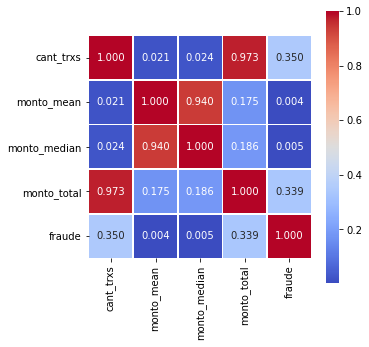

In [31]:
corr_df = Data_df.corr()
plt.figure(figsize = (5,5))
sns.heatmap(corr_df, cmap="coolwarm", linewidths=.5, square=True, annot=True, fmt='.3f')

In [32]:
Data_F = Data_df[['cant_trxs','monto_total','establecimiento_mode','tipo_tc_mode','fraude']]

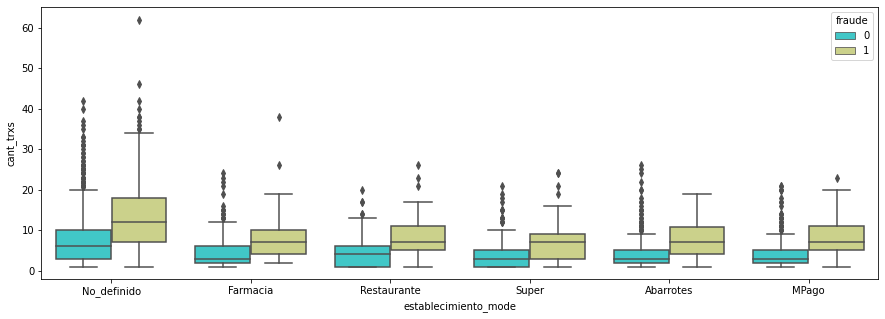

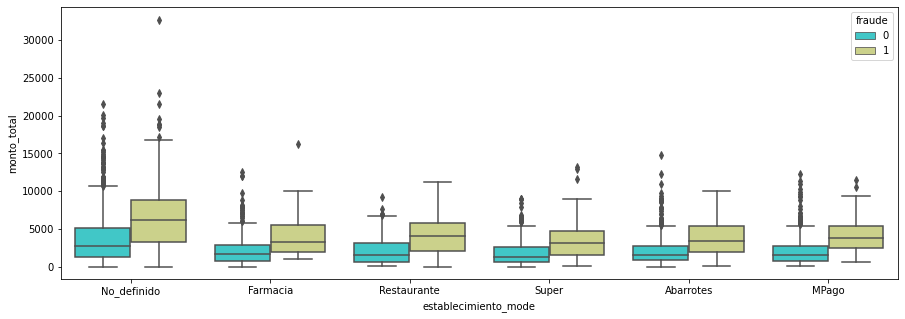

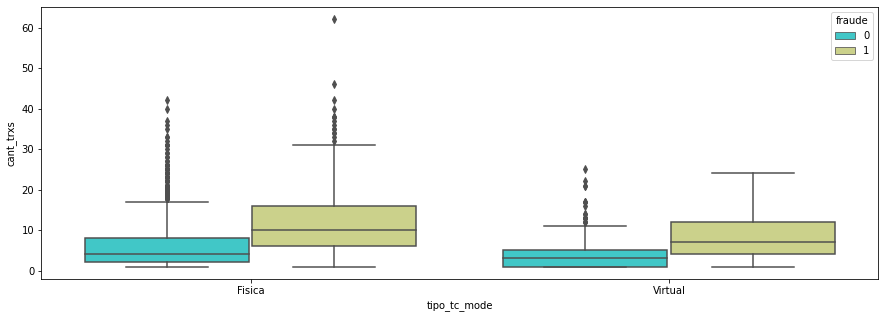

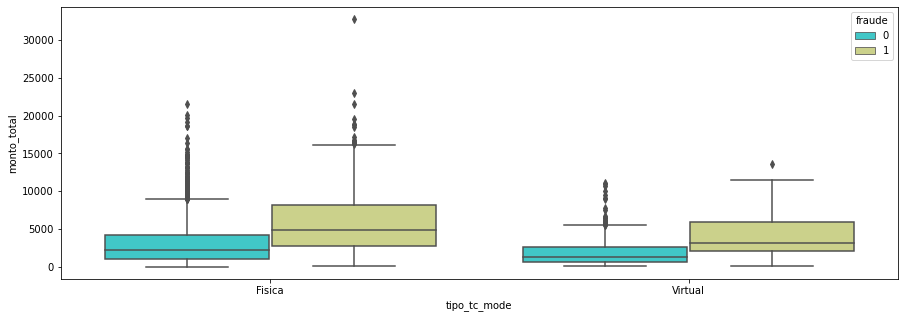

In [33]:
for cat in ['establecimiento_mode','tipo_tc_mode']:
    for num in ['cant_trxs','monto_total']: 
        plt.subplots(figsize=(15, 5))
        sns.boxplot(x=cat, y=num, data=Data_F, palette='rainbow', hue="fraude" )

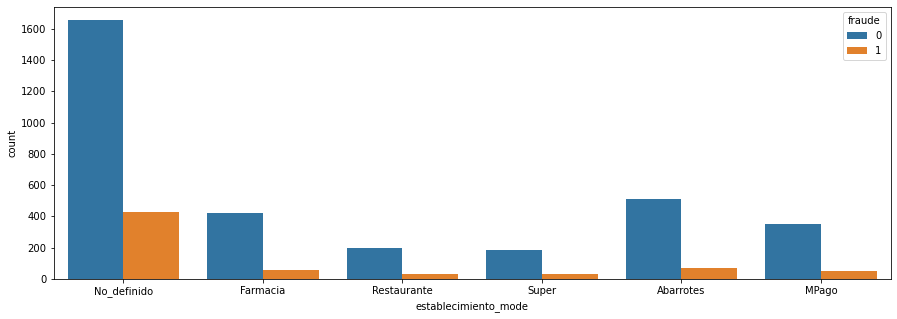

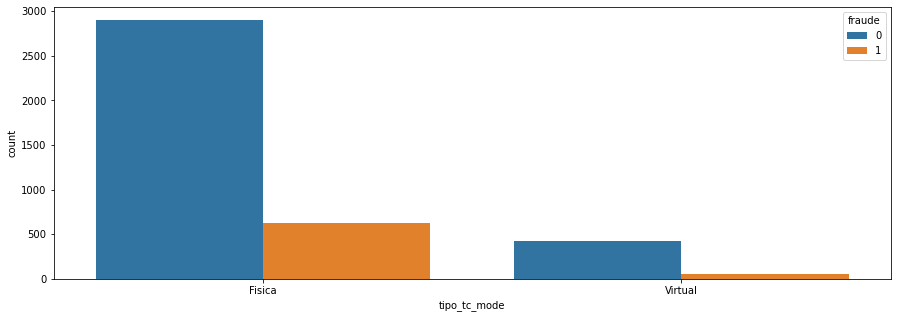

In [34]:
for col in ['establecimiento_mode','tipo_tc_mode']:
    plt.subplots(figsize=(15, 5))
    sns.countplot(x=col,data=Data_F, hue="fraude")

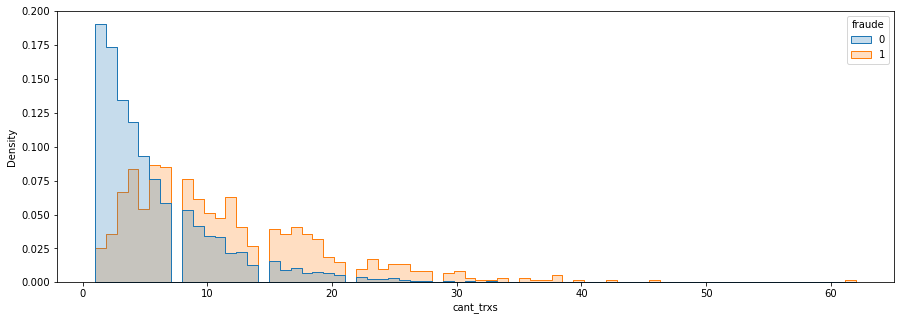

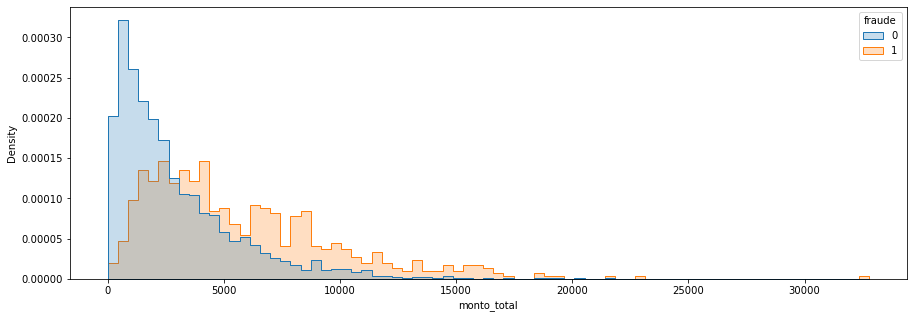

In [35]:
for col in ['cant_trxs','monto_total']:
    plt.subplots(figsize=(15, 5))
    #sns.kdeplot(data=Data_F, x=col, hue="fraude" )
    sns.histplot(data=Data_F, x=col, hue="fraude", element="step", stat="density", common_norm=False)

In [36]:
Data_F[Data_F['fraude']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
cant_trxs,3325.0,5.769323,5.231180,1.000000,2.000000,4.000000,8.000000,42.000000
monto_total,3325.0,2881.076951,2704.723524,2.038424,923.758692,2060.998202,3955.243048,21524.940857
fraude,3325.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
print(Data_F[Data_F['fraude']==0]['monto_total'].mean())
print(Data_F[Data_F['fraude']==0]['monto_total'].median())
print(4*"------")
print(Data_F[Data_F['fraude']==0]['cant_trxs'].mean())
print(Data_F[Data_F['fraude']==0]['cant_trxs'].median())

2881.0769507324935
2060.998202389531
------------------------
5.7693233082706765
4.0


In [38]:
Data_F['cant_trxs_Q'] = pd.qcut(Data_F['cant_trxs'], 4, labels=['q1','q2','q3','q4'])
Data_F['monto_total_Q'] = pd.qcut(Data_F['monto_total'], 4, labels=['q1','q2','q3','q4'])
Data_F.sample(2)

,cant_trxs,monto_total,establecimiento_mode,tipo_tc_mode,fraude,cant_trxs_Q,monto_total_Q
ID_USER,,,,,,,
3186,1,442.675590,Farmacia,Fisica,0,q1,q1
1444,4,2759.457519,No_definido,Fisica,0,q2,q3


In [39]:
Data_F.groupby('monto_total_Q').agg({'monto_total': ['count','mean', 'median','min','max']})

monto_total                                                     
                    count         mean       median          min           max
monto_total_Q                                                                 
q1                   1000   593.526922   630.019050     2.038424   1071.758421
q2                   1000  1703.476261  1696.904370  1074.151120   2357.848780
q3                   1000  3359.134884  3336.330016  2359.739827   4573.732275
q4                   1000  7806.261495  6858.784676  4575.723736  32756.785742

In [40]:
aux = Data_F.groupby(['tipo_tc_mode','establecimiento_mode','cant_trxs_Q']).agg( # monto_total_Q
    cant = ('fraude', 'count'),
    fraude_avg = ('fraude', 'mean'),
    fraude_sum = ('fraude', 'sum')
).reset_index()
aux.head(3)

,tipo_tc_mode,establecimiento_mode,cant_trxs_Q,cant,fraude_avg,fraude_sum
0,Fisica,Abarrotes,q1,169,0.047337,8
1,Fisica,Abarrotes,q2,185,0.070270,13
2,Fisica,Abarrotes,q3,97,0.226804,22


In [41]:
print(aux['cant'].sum())
aux = aux[aux['cant']>0]
aux['cant_per'] =  aux['cant']/aux['cant'].sum()
aux['fraude_per'] =  aux['fraude_sum']/aux['fraude_sum'].sum()
aux['new'] =  aux['cant_per']*aux['fraude_avg']
aux = aux.sort_values(by=['new','cant_per'], ascending=[False,False])
aux["fraude_per_A"]=aux['fraude_per'].cumsum(axis=0)
aux

4000


,tipo_tc_mode,establecimiento_mode,cant_trxs_Q,cant,fraude_avg,fraude_sum,cant_per,fraude_per,new,fraude_per_A
15,Fisica,No_definido,q4,683,0.364568,249,0.17075,0.368889,0.06225,0.368889
14,Fisica,No_definido,q3,441,0.199546,88,0.11025,0.130370,0.02200,0.499259
13,Fisica,No_definido,q2,434,0.133641,58,0.10850,0.085926,0.01450,0.585185
2,Fisica,Abarrotes,q3,97,0.226804,22,0.02425,0.032593,0.00550,0.617778
3,Fisica,Abarrotes,q4,64,0.343750,22,0.01600,0.032593,0.00550,0.650370
10,Fisica,MPago,q3,65,0.307692,20,0.01625,0.029630,0.00500,0.680000
6,Fisica,Farmacia,q3,94,0.170213,16,0.02350,0.023704,0.00400,0.703704
11,Fisica,MPago,q4,47,0.340426,16,0.01175,0.023704,0.00400,0.727407
7,Fisica,Farmacia,q4,45,0.355556,16,0.01125,0.023704,0.00400,0.751111
39,Virtual,No_definido,q4,40,0.350000,14,0.01000,0.020741,0.00350,0.771852


In [42]:
Data_F['segment_fraude'] = 'Bajo'
Data_F['segment_fraude'] = Data_F[['tipo_tc_mode','establecimiento_mode','cant_trxs_Q','segment_fraude']]\
    .apply(lambda x: 'Alto' if (x[0]=='Fisica' and x[1]=='No_definido' and x[2] in ['q2','q3','q4'] ) else x[3], axis=1)
Data_F['segment_fraude'] = Data_F[['tipo_tc_mode','establecimiento_mode','cant_trxs_Q','segment_fraude']]\
    .apply(lambda x: 'Medio' if (x[0]=='Fisica' and x[1]!='No_definido' and x[2] in ['q2','q3','q4'] ) else x[3], axis=1)

  segment_fraude  customers  customers_fraude  fraude_ratio  share_fraude
0           Alto       1558               395      0.253530      0.585185
1           Bajo       1368                85      0.062135      0.125926
2          Medio       1074               195      0.181564      0.288889


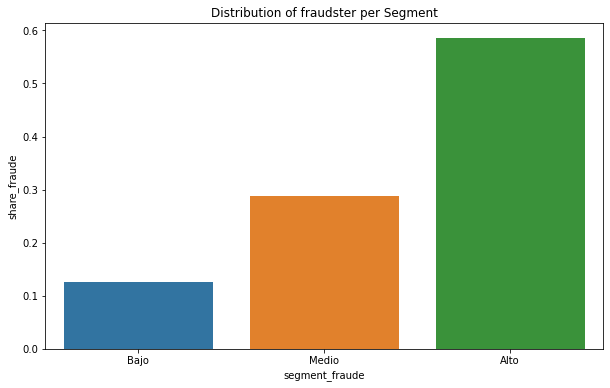

In [43]:
df_plot = Data_F.groupby('segment_fraude',as_index=False).agg(
    customers = ('fraude', 'count'),
    customers_fraude = ('fraude', 'sum'),
    fraude_ratio = ('fraude', 'mean'),
)
df_plot['share_fraude'] = df_plot['customers_fraude'] / df_plot['customers_fraude'].sum()
print(df_plot)
plt.figure(figsize=(10,6))
sns.barplot(data = df_plot, x='segment_fraude',y='share_fraude', order=['Bajo','Medio','Alto'])
plt.title('Distribution of fraudster per Segment')
plt.show()